In [1]:
%matplotlib inline
%run support.py
import os
plt.style.use('~/Shared JupyterHub Notebooks/interactive.mplstyle')
#datafolder = "/mnt/Measurement_Data/phys-dots-26/Cooldown20200826"
datafolder = "./data/Measurements/Cooldown20200826"
import matplotlib.gridspec as gridspec
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.interpolate import interp2d
from pathlib import Path

In [2]:
warmup_rules = {
    "60mT": {"finalfield": 0.060, "label": " 60 mT", "datafiles": [526, 527], "heatfitrange": (20, 27), "noise": 1.1e-6, "leakerrorregion": (14,21)},
    "90mT": {"finalfield": 0.090, "label": " 90 mT", "datafiles": [564], "heatfitrange": (20, 36.25), "noise": 0.8e-6, "leakerrorregion": (8,24)},
    "120mT": {"finalfield": 0.120, "label": "120 mT", "datafiles": [516, 517, 518, 519], "heatfitrange": (0, 39.5), "noise": 0.8e-6, "leakerrorregion": (0,33)},
    "150mT": {"finalfield": 0.150, "label": "150 mT", "datafiles": [646, 647], "heatfitrange": (10, 52), "noise": 0.8e-6, "leakerrorregion": (29,46)}
               }
#"150mT": {"finalfield": 0.150, "label": "150 mT", "datafiles": [567, 568, 569, 570], "heatfitrange": (0, 45), "noise": 0.8e-6, "leakerrorregion": (29,46)}
#"50mT": {"finalfield": 0.050, "label": " 50 mT", "datafiles": [640], "heatfitrange": (20, 26), "noise": 0.7e-6, "leakerrorregion": (14,21)},

warmup_results = {}
for key in warmup_rules:
    warmup_results[key] = {}

rng = slice(1,-1)  # In each trace, the first and the last points are not included in the fit, because the first point sometimes looks unsettled.
    
for key in warmup_rules:
    warmup_results[key]["t"], warmup_results[key]["g0"] = [], []
    filenums = warmup_rules[key]["datafiles"]
    for i, fn in enumerate(filenums):
        filename = f"d{fn}_time_c12.h5"
        with h5py.File(f"{datafolder}/{filename}", 'r') as f:
            t = np.array(f['x_array'])[10:]
            v = np.array(f['y_array'])
            gCu = np.array(f['gCu'])[:,10:]
        gCu = 1/(1/gCu - 2*R_wire)

        warmup_results[key]["t"].extend(t)
        warmup_results[key]["g0"].extend(np.mean(gCu[int(gCu.shape[0]/2)-3:int(gCu.shape[0]/2)+3,:], axis=0))
        #g0s = np.zeros(len(t))    
        #warmup_results[key]["g0"].extend(g0s)
    warmup_results[key]["g0"] = MakeSmoothie(warmup_results[key]["g0"], ws=10)

with h5py.File(f"{datafolder}/d640_time_c12.h5") as f:
    warmup_50mT_t = np.array(f['x_array'])
    warmup_50mT_v = np.array(f['y_array'])
    gCu = np.array(f['gCu'])
warmup_50mT_t -= warmup_50mT_t[0]
gCu = 1/(1/gCu - 2*R_wire)
warmup_50mT_gCu = np.mean(gCu[int(gCu.shape[0]/2)-3:int(gCu.shape[0]/2)+3,:], axis=0)
warmup_50mT_gCu = MakeSmoothie(warmup_50mT_gCu)
warmup_50mT_T = Tcbt_Cu(warmup_50mT_gCu/gT_Cu, Ec=Ec_Cu*1e-3)
    
# Fit to 1/T
fit_1T_warmup = {}
for i, key in enumerate(warmup_results):
    t = warmup_results[key]["t"]-warmup_results[key]["t"][0]
    Bf = warmup_rules[key]["finalfield"]
    
    OneOverT = 1/(Tcbt_Cu(np.array(warmup_results[key]["g0"])/gT_Cu, Ec=Ec_Cu*1e-3))
    #start_from_fit = warmup_rules[key]["heatfitrange"][0] #starts[np.argmax(R2s)]
    flt = np.logical_and(t/3600>warmup_rules[key]["heatfitrange"][0], t/3600<warmup_rules[key]["heatfitrange"][1])
    
    linfit, cov = np.polyfit(t[flt], OneOverT[flt], 1, cov=True)
    m_std = np.sqrt(cov[0,0])

    Qdot = -Cu_CC * Bf**2 / (mu0 * (1/linfit[0] + Cu_Korringa))
    QdotUp = -Cu_CC * Bf**2 / (mu0 * (1/(linfit[0]-m_std) + Cu_Korringa))
    QdotLo = -Cu_CC * Bf**2 / (mu0 * (1/(linfit[0]+m_std) + Cu_Korringa))
    Qdotavgerr = (QdotUp - QdotLo)/2
   
    warmup_results[key]["heatleak"] = [Qdot, Qdotavgerr, linfit]

print("Done!")


Done!


/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


In [3]:
# Load MC traces
tracefiles = [x for x in Path("./data/MC_VsdTraces").rglob("*.mat")]
mc_temps, mc_Vs, mc_ggTs = [], [], []
for i in range(len(tracefiles)):
    filecontent = loadmat(tracefiles[i])
    mc_temps.append(float(os.path.basename(tracefiles[i]).split('.')[0])*1e-6)
    mc_Vs.append(np.array(filecontent['VbFull'][0]))
    mc_ggTs.append(np.array(filecontent['GovGT20Full'][:,0]))
    
vv, tt = np.meshgrid(mc_Vs[0], mc_temps)

g_int = interp2d(mc_Vs[0], mc_temps, mc_ggTs, kind='cubic')

v_fine = np.arange(np.min(mc_Vs), np.max(mc_Vs), 0.1e-6)
T_fine = np.arange(np.min(mc_temps), np.max(mc_temps), 1e-6)
vv_fine, TT_fine = np.meshgrid(v_fine, T_fine)
gg_fine = g_int(v_fine, T_fine)
gg0_fine = gg_fine[np.abs(vv_fine)<1e-9]
ggT_avgs = np.zeros(T_fine.shape[0])

for key in warmup_rules:
    for i, T in enumerate(T_fine):
        noise = warmup_rules[key]["noise"]
        v_random = np.random.normal(loc=0, scale=noise, size=4000)
        #print(v_random.shape, v_fine.shape, gg_fine[i,:].shape)
        ggT_random = np.interp(v_random, v_fine, gg_fine[i,:])
        ggT_avg = np.average(ggT_random)
        ggT_avgs[i] = ggT_avg
        T_avgggT = Tcbt_Cu(ggT_avg, Ec=Ec_Cu)
    T_fine_corrected = Tcbt_Cu(ggT_avgs, Ec=Ec_Cu)
    warmup_results[key]["T_fine_corrected"] = T_fine_corrected
    print(key, T_fine_corrected[-3:-1])

60mT [1.46187215 1.46259343]
90mT [1.45604312 1.45688952]
120mT [1.4555024  1.45716804]
150mT [1.45603391 1.45686971]


# Calculate noised temperature for every fine_T

In [4]:
N = 4000
noises = np.array([0.5, 0.8, 1.1, 1.4])*1e-6
v_randoms = np.zeros((len(noises), N))
ggT_avgs = np.zeros((len(noises), len(T_fine)))
for i, noise in enumerate(noises):
    v_randoms[i,:] = np.random.normal(loc=0, scale=noise, size=N)
    ggT_random = np.zeros((len(T_fine), N))
    print(f"Calculating the noise effect for noise={noise*1e6:3.1f} µV ({i*100/len(noises):.0f}%)", end='\r')
    for j in range(len(T_fine)):
        ggT_random[j,:] = np.interp(v_randoms[i,:], v_fine, gg_fine[j,:])
    ggT_avgs[i,:] = np.average(ggT_random, axis=1)
print("Done!                                                       ")

Done!                                                       


/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/var/opt/jupyterhub/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


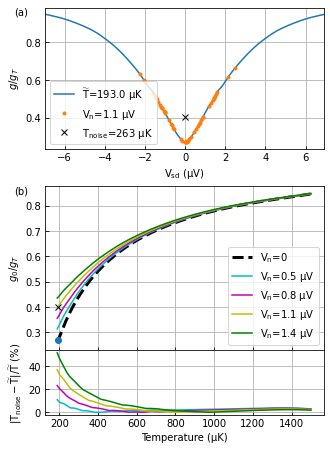

In [5]:
Treal = 193*1e-6; Treal_index = np.min(np.where(T_fine>Treal));
T1 = 190*1e-6
T2 = 200*1e-6
noise_index = 2
if Treal < T1 or Treal > T2 or T1 > T2:
    print("Hey. This is not how I am programmed to do stuff.")


#fig, ax = plt.subplots(3,1,figsize=(5, 8), gridspec_kw={'height_ratios': [2, 2, 1]})
fig = plt.figure(figsize=(5, 7.5))
outer_gs = gridspec.GridSpec(2, 1, height_ratios = [3.7, 6], hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = outer_gs[0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec = outer_gs[1], hspace=0, height_ratios = [5, 2])
ax=[]
ax.append(plt.subplot(gs1[0]))
ax.append(plt.subplot(gs2[0]))
ax.append(plt.subplot(gs2[1]))

ax[0].plot(v_fine*1e6, gg_fine[Treal_index,:], label=f"$\mathrm{{\widetilde{{T}}}}$={Treal*1e6} µK")
ax[0].set_xlim(np.min(v_fine)*1e6, np.max(v_fine)*1e6)

ggT_random = np.interp(v_randoms[noise_index,:], v_fine, gg_fine[Treal_index,:])
ax[0].plot(v_randoms[noise_index,0:50]*1e6, ggT_random[0:50], '.', label=f"$\mathrm{{V_n}}$={noises[noise_index]*1e6:.1f} µV")
g0gT_noised = ggT_avgs[noise_index, Treal_index]
T_noised = Tcbt_Cu(g0gT_noised, Ec=Ec_Cu)
ax[0].plot([0], [ggT_avgs[noise_index, Treal_index]], 'xk', label=f"$\mathrm{{T_{{noise}}}}$={T_noised*1e3:.0f} µK")
#ax[0].text(-6.5, 0.53, f"$\mathrm{{V_n}}$={noises[noise_index]*1e6:.1f} µV")
#ax.set_xlim(-1.5,1.5)
#ax.set_ylim(0.25, 0.7)
ax[0].set_xlabel(r"$\mathrm{V_{sd}}$ (µV)")
ax[0].set_ylabel(r"$g/g_T$")

ax[1].plot(T_fine*1e6, gg0_fine, '--k', lw=3, label=r'$\mathrm{V_n}$=0')
for i, noise in enumerate(noises):
    ax[1].plot(T_fine*1e6, ggT_avgs[i,:], label=f"$\mathrm{{V_n}}$={noises[i]*1e6:.1f} µV", color="cmyg"[i])
    
# Mark the points from the plot above
ax[1].plot([Treal*1e6], [np.min(gg_fine[Treal_index,:])], 'o', color=colors[0])
ax[1].plot([Treal*1e6], [ggT_avgs[noise_index, Treal_index]], 'xk')

ax[1].set_ylabel(r"$g_0/g_T$")
ax[1].set_xticklabels([])

for i, noise in enumerate(noises):
    T_noised = Tcbt_Cu(ggT_avgs[i,:], Ec=Ec_Cu*1e-3)
    ax[2].plot(T_fine*1e6, 100*np.abs(T_noised-T_fine)/T_fine, label=f"$\mathrm{{V_n}}$={noises[i]*1e6:.1f} µV", color="cmyg"[i])

ax[2].set_xlabel("Temperature (µK)")
ax[2].set_ylabel(r"$\mathrm{|T_{noise}-\widetilde{T}|/\widetilde{T}}$ (%)")

for i in range(2):
    ax[i].legend()
    ax[i].grid()
    ax[i].text(-0.11, 0.95, f"({'abcdefghijklmnopqrstuvwxyz'[i]})", transform=ax[i].transAxes)
ax[2].grid()

fig.savefig("voltagenoise.pdf", transparent=True, bbox_inches='tight', pad_inches=0.01)

/var/opt/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/var/opt/jupyterhub/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


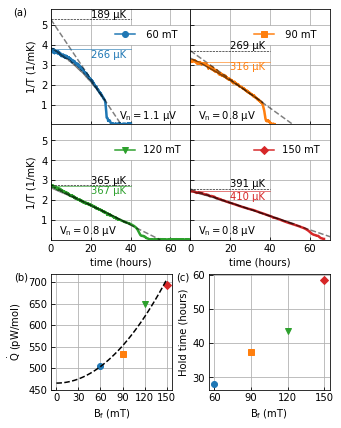

In [6]:
fig = plt.figure(figsize=(5, 7))
outer_gs = gridspec.GridSpec(2, 1, height_ratios = [2, 1], hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_gs[0], hspace=0, wspace=0)
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], wspace=0.3)
ax=[]
for i in range(4):
    ax.append(plt.subplot(gs1[i]))
ax.append(plt.subplot(gs2[0]))
ax.append(plt.subplot(gs2[1]))

T0s = []

# Plot 4 warm-up curves
extrapT = np.zeros(len(warmup_results))
for i, key in enumerate(warmup_results):
    Qdot, Qdotavgerr, linfit = warmup_results[key]["heatleak"]
    t = warmup_results[key]["t"]-warmup_results[key]["t"][0]
    
    label = f"{warmup_rules[key]['label']}" #"\n$\dot{{Q}}$={Qdot*1e12:.0f} pW/mol\n$V_{{noise}}$={warmup_rules[key]['noise']*1e6:.1f} µV\nd{str(warmup_rules[key]['datafiles'])}"
    #loc = (0.43, 0.7) if i==0 else 'best'
    ax[i].legend(handles=[mpl.lines.Line2D([0], [0], marker='osvD'[i], color=colors[i], label=label)], loc=(0.43, 0.7), framealpha=1.0, edgecolor='w')
    
    ax[i].plot(t/3600, 1/(Tcbt_Cu(np.array(warmup_results[key]["g0"])/gT_Cu, Ec=Ec_Cu*1e-3)*1e3), alpha=1.0, color=colors[i], lw=2.5) #, label="Data")
      
    #fltfit = np.logical_and(t/3600>starts[np.argmax(R2s)], t/3600<warmup_rules[key]["heatfitrange"][1])
    fltfit = np.logical_and(t/3600>warmup_rules[key]["heatfitrange"][0], t/3600<warmup_rules[key]["heatfitrange"][1])
    fltalllinear = t/3600<warmup_rules[key]["heatfitrange"][1]
    linfit_temp = np.poly1d(linfit)(t[fltalllinear])
    linfitlinear_temp = np.poly1d(linfit)(t[fltfit])
    corrected_temp = np.interp(1/linfit_temp, T_fine, warmup_results[key]["T_fine_corrected"])*1e-3
    #ax[i].plot(t[fltfit]/3600, linfitlinear_temp*1e-3, '--', color='k') #, label="Fit region")
    
    t_intercept = -linfit[1]/linfit[0]
    displaylinefit_temp = np.poly1d(linfit)([0, t_intercept])
    
    ax[i].plot([0, t_intercept/3600], displaylinefit_temp*1e-3, '--', color='k', alpha=0.5)
    extrapT[i] = 1/linfit_temp[0]
    ax[i].plot(t[fltalllinear]/3600, 1e-3/corrected_temp, '-', color='k', alpha=0.5) #, label="Corrected for V noise")
    
    T0 = Tcbt_Cu(np.array(warmup_results[key]["g0"][0])/gT_Cu, Ec=Ec_Cu*1e-3)
    T0s.append(T0)
    warmup_results[key]["T0"] = T0
    
    # Indicate the temperature at t=0
    ax[i].plot([0, 40], [1e-3/T0s[i]]*2, color=colors[i], lw=0.6)
    ax[i].text(20, 1e-3/T0s[i]-0.4, f"{Tcbt_Cu(np.mean(warmup_results[key]['g0'][0:10])/gT_Cu, Ec=Ec_Cu)*1e3:.0f} µK", color=colors[i], zorder=10)
    # and the back-extrapolated temperature too
    #pushleft = 18 if i==0 else 0
    ax[i].plot([0, 40], [1e-3/extrapT[i]]*2, '--', color='k', lw=0.6)
    ax[i].text(20, 1e-3/extrapT[i]+0.1, f"{extrapT[i]*1e6:.0f} µK", color='k', zorder=10)
    
    # indicate the noise level
    pushright = 30 if i==0 else 0
    ax[i].text(4 + pushright, 0.3, f"$\mathrm{{V_{{n}}}}=${warmup_rules[key]['noise']*1e6:.1f} µV")   
   
    
# Format the top 4 plots.
ax[0].set_xticklabels([]);ax[1].set_xticklabels([]);ax[1].set_yticklabels([]);ax[3].set_yticklabels([])
ax[2].set_xlabel("time (hours)"); ax[3].set_xlabel("time (hours)");
ax[0].set_ylabel("1/T (1/mK)"); ax[2].set_ylabel("1/T (1/mK)")
for i in range(4):
    ax[i].set_xlim(0,70)
    ax[i].set_ylim(0,5.8)
    ax[i].set_xticks(np.linspace(0,60,4))
    ax[i].set_yticks(range(1,6))
    ax[i].grid()

# Heat leak parabola
Bfs, Qdots = [], []
for i, key in enumerate(warmup_results):
    Qdot, Qdotavgerr, linfit = warmup_results[key]["heatleak"]
    Bf = warmup_rules[key]["finalfield"]
    ax[4].plot([Bf*1e3], [Qdot*1e12], marker='osvD'[i]) # Qdotavgerr
    Bfs.append(Bf)
    Qdots.append(Qdot)

parabolazero = lambda x, a, c: a*x*x + c
popt, pcov = curve_fit(parabolazero, Bfs, Qdots, p0=None)
a, b, c = popt[0], 0, popt[1]
polynom = np.poly1d([a,b,c])
Bs = np.linspace(0.0, 0.150)
Qs = polynom(Bs)

#ax[4].plot([-b/(2*a)], [1e12*(-b*b+4*a*c)/(4*a)], 'xk')
ax[4].plot(Bs*1e3, Qs*1e12, '--k')

ax[4].set_xlabel("$\mathrm{{B_f}}$ (mT)")
ax[4].set_ylabel(r"$\mathrm{{\dot{Q}}}$ (pW/mol)")
ax[4].set_xticks(np.linspace(0, 150, 6))#[0, 60, 90, 120, 150])
ax[4].set_yticks(np.linspace(450, 700, 6))#[1e12*(-b*b+4*a*c)/(4*a), 500, 600, 700]) 
ax[4].grid()

# Hold times
holdtimes, Bfs = [], []
for i, key in enumerate(warmup_results):
    t = warmup_results[key]["t"]-warmup_results[key]["t"][0]
    temp = Tcbt_Cu(np.array(warmup_results[key]["g0"])/gT_Cu, Ec=Ec_Cu*1e-3)
    threshold_index = np.min(np.where(temp > 2e-3))
    ax[5].plot([warmup_rules[key]["finalfield"]*1e3], [t[threshold_index]/3600], 'osvD'[i], color=colors[i])
    Bfs.append(warmup_rules[key]["finalfield"])
    holdtimes.append(t[threshold_index])
    
linfit = np.polyfit(Bfs, holdtimes, 1)
poly = np.poly1d(linfit)

ax[5].set_xticks(np.linspace(60, 150, 4))
ax[5].set_xlabel("$\mathrm{{B_f}}$ (mT)")
ax[5].set_ylabel(r"Hold time (hours)")
ax[5].grid()

ax[0].text(-0.27, 0.95, "(a)", transform=ax[0].transAxes)
ax[4].text(-0.30, 0.95, "(b)", transform=ax[4].transAxes)
ax[5].text(-0.27, 0.95, "(c)", transform=ax[5].transAxes)

fig.savefig('heatleaks.pdf', transparent=True, bbox_inches='tight', pad_inches=0.01)

Text(0, 0.5, '$T_f$ (µK)')

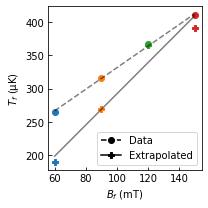

In [7]:
fig, ax = plt.subplots(figsize=(3,3))
for i, key in enumerate(warmup_results):
    ax.plot([np.array(Bfs)[i]*1e3], [np.array(T0s)[i]*1e6], 'o', color=colors[i])
    ax.plot([np.array(Bfs)[i]*1e3], [extrapT[i]*1e6], 'P', color=colors[i])
fitBs = np.linspace(0.060, 0.150)
linfitData = np.polyfit(Bfs, T0s, 1)
ax.plot(fitBs*1e3, np.poly1d(linfitData)(fitBs)*1e6, '--k', alpha=0.5)
linfitExtrap = np.polyfit(Bfs, extrapT, 1)
ax.plot(fitBs*1e3, np.poly1d(linfitExtrap)(fitBs)*1e6, '-k', alpha=0.5)

ax.legend(handles=[
            mpl.lines.Line2D([0], [0], marker='o', ls='--', color='k', label='Data'), 
            mpl.lines.Line2D([0], [0], marker='P', ls='-', color='k', label='Extrapolated')])

ax.set_xlabel(r"$B_f$ (mT)")
ax.set_ylabel(r"$T_f$ (µK)")

0.013041719543797391 0.0002650097174551828 9 0.06
0.014010559185033073 0.00031593057080140394 9 0.09
0.015764700517285263 0.0003672384299392101 9 0.12
0.015764700517285263 0.0004099241088119449 9 0.15


Text(0.5, 1.0, 'Adiabatic Efficiency')

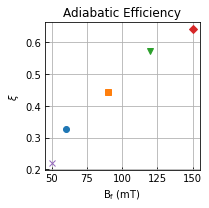

In [8]:
demag_g00 = {
    "60mT": {"finalfield": 0.060, "g00": 18.10e-6},
    "90mT": {"finalfield": 0.090, "g00":  18.12e-6},
    "120mT": {"finalfield": 0.120, "g00": 18.15e-6},
    "150mT": {"finalfield": 0.150, "g00": 18.15e-6}
}

fig, ax = plt.subplots(figsize=(3,3))
for i, key in enumerate(demag_g00):
    g00 = 1/(1/demag_g00[key]["g00"] - 2*R_wire)
    Ti = Tcbt_Cu(g00/gT_Cu, Ec=Ec_Cu*1e-3)
    Tf = warmup_results[key]["T0"]
    Bi = 9
    Bf = demag_g00[key]["finalfield"]
    xi = (Ti/Tf)/(Bi/Bf)
    print(Ti, Tf, Bi, Bf)
    ax.plot([Bf*1e3], [xi], 'osvD'[i])
ax.plot([50], [0.22], 'x')
ax.grid()
ax.set_xlabel(r"$\mathrm{B_f}$ (mT)")
ax.set_ylabel(r"$\xi$")
ax.set_title("Adiabatic Efficiency")

In [9]:
Qdot = 500e-12
Bf = 0.060
Te = 189e-6
Tn = Te/(1+(mu0 * Cu_Korringa * Qdot)/(Cu_CC * Bf*Bf))
print(f"Tn={1e6*Tn} µK")
print(f"(Te-Tn)/Tn={100*(Te-Tn)/Tn:.1f}%")
nmol = (5e-6 * 39e-6 * 206e-6) * Cu_rho / Cu_atomicmass
print(f"{Qdot * nmol * 1e18:.1f} W/island")


# Compare to Geresdi's 500 µK paper
Geresdi_Qdot_perisland = 26.8e-18 
Geresdi_nmol = 11.4e-9   # moles per island
Geresdi_Qdot_permole = Geresdi_Qdot_perisland / Geresdi_nmol
print(f"Geresdi Heat Leak per Mole: {Geresdi_Qdot_permole*1e9:.1f} nW/mol")

Tn=179.54238405254003 µK
(Te-Tn)/Tn=5.3%
2.8 W/island
Geresdi Heat Leak per Mole: 2.4 nW/mol


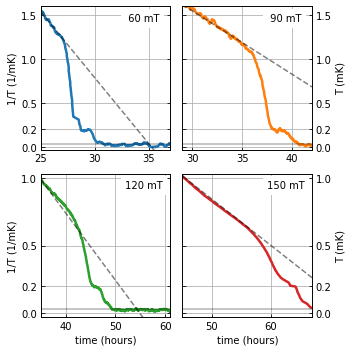

In [10]:
fig, ax = plt.subplots(2,2, figsize=(5,5))
axr = []
T_min, T_max = 1e-3, 22e-3
warmup_rules["60mT"]["zoomedhours"] = (25, 37)
warmup_rules["90mT"]["zoomedhours"] = (29, 42)
warmup_rules["120mT"]["zoomedhours"] = (35, 61)
warmup_rules["150mT"]["zoomedhours"] = (45, 67)
yticks = np.array([0, 0.2, 0.5, 1, 1.5])
yticklabelsRight = np.array([r"$\infty$", "5", "2", "1", "0.7"])

for i, key in enumerate(warmup_rules):
    r,c = int(i/2), int(i%2)
    t = warmup_results[key]["t"]-warmup_results[key]["t"][0]
    Tcbt = Tcbt_Cu(np.array(warmup_results[key]["g0"])/gT_Cu, Ec=Ec_Cu*1e-3)
    ax[r,c].plot(t/3600, 1/Tcbt*1e-3, lw=2.5, color=colors[i])
    ax[r,c].text(0.65, 0.9, f"{warmup_rules[key]['label']}", transform=ax[r,c].transAxes, backgroundcolor='w')
    ax[r,c].set_xlim(warmup_rules[key]["zoomedhours"])
    ax[r,c].grid()
    
    axr.append(ax[r,c].twinx())
    ax[r,c].set_yticks(yticks)
    axr[i].set_yticks(yticks)
    ax[r,c].axhline(y=0.03, color="black", alpha=0.3)

    Qdot, Qdotavgerr, linfit = warmup_results[key]["heatleak"]
    fltfit = np.logical_and(t>warmup_rules[key]["zoomedhours"][0]*3600, t<warmup_rules[key]["zoomedhours"][1]*3600)
    linfit_temp = np.poly1d(linfit)(t[fltfit])
    ax[r,c].plot(t[fltfit]/3600, linfit_temp*1e-3, '--', color='k', alpha=0.5)

axr = np.array(axr).reshape((2,2))
    
for i in range(2):
    ax[0,i].set_ylim(-0.03, 1.6)
    axr[0,i].set_ylim(-0.03, 1.6)
    
    ax[1,i].set_ylim(-0.03, 1.03)
    axr[1,i].set_ylim(-0.03, 1.03)
    
    ax[1,i].set_xlabel("time (hours)")
    ax[i,0].set_ylabel("1/T (1/mK)")
    axr[i,1].set_ylabel("T (mK)")
    ax[i,1].set_yticklabels([])
    axr[i,0].set_yticklabels([])
    
fig.savefig('heatleaks_highTzoomed.pdf', transparent=True, bbox_inches='tight', pad_inches=0.01)